In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


In [2]:
df=pd.read_csv('AirPassengers.csv')
df=df.rename(columns={'#Passengers':'passengers','Month':'date'})
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)
df=df.drop(columns=['date'])
df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
# CHECK FOR NULL VALUES
df.isnull().sum()

passengers    0
dtype: int64

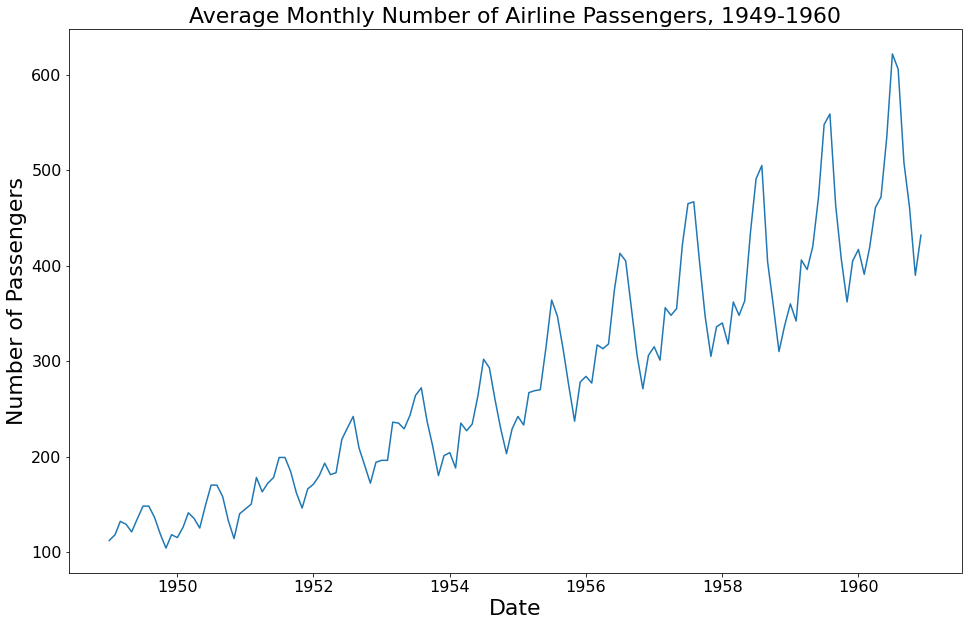

In [4]:
# Set figure size
plt.figure(figsize=(16,10))

# Create Line Plot
plt.plot(df['passengers'])

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Number of Passengers', fontsize=22)
plt.title('Average Monthly Number of Airline Passengers, 1949-1960', fontsize=22);

Text(0.5, 1.0, 'Distribution of Passengers')

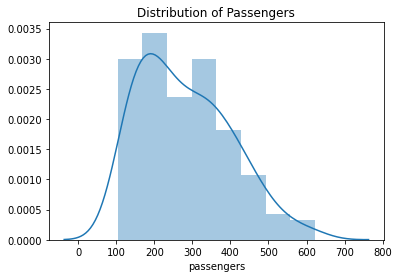

In [5]:
sns.distplot(df['passengers'])
plt.title('Distribution of Passengers')

<Figure size 432x288 with 0 Axes>

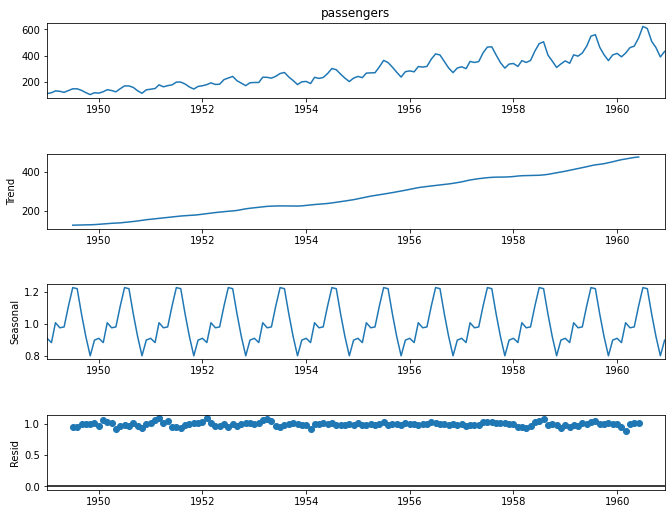

In [6]:
seasonal = seasonal_decompose(df.passengers,model='multiplicative')
fig = plt.figure()  
fig = seasonal.plot()  
fig.set_size_inches(10, 8)

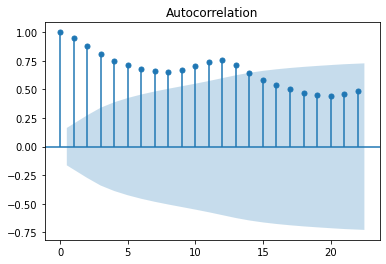

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['passengers']);


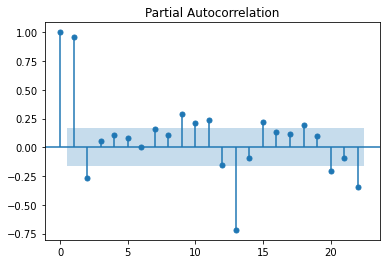

In [8]:
plot_pacf(df['passengers']);


In [9]:
# Dickey-Fuller Test
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

interpret_dftest(adfuller(df['passengers']))

Test Statistic    0.815369
p-value           0.991880
dtype: float64

Since $\alpha$ < p-value = 0.18, we cannot reject the null hypothesis. So, I will take the difference and perform the test again.

In [46]:
interpret_dftest(adfuller(df['passengers'].diff().dropna()))


Test Statistic   -2.829267
p-value           0.054213
dtype: float64

In [58]:
interpret_dftest(adfuller(df['passengers'].diff().diff().dropna()))


Test Statistic   -1.638423e+01
p-value           2.732892e-29
dtype: float64

<AxesSubplot:xlabel='date'>

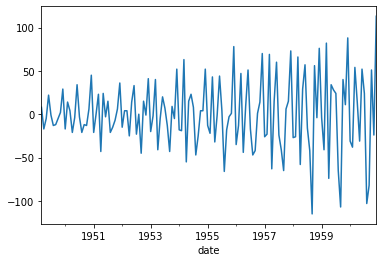

In [83]:
difference_df=df['passengers'].diff().diff().dropna()
difference_df.plot()

Since $\alpha$ > p-value, we can reject the null hypothesis and accept the alternative hypothesis that the data is stationary. We can now model our time series data by setting the difference hyperparameter to 2.

Let's look at the ACF/ PACF plots using the differenced data to visualize the lags that will likely be influencial when modeling the number of passengers.

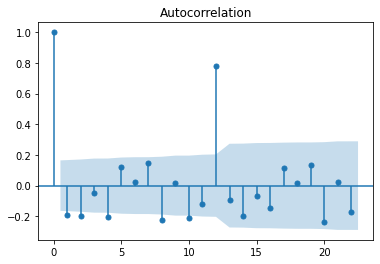

In [84]:
plot_acf(difference_df);
# MA terms (q=2)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


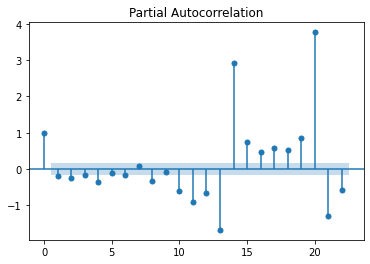

In [85]:
plot_pacf(difference_df);
# AR terms(p= 0)

In [14]:
df.tail()

,passengers
date,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [33]:
train=df[:114]
test=df[-30:]

In [86]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(endog = train.astype(float).dropna(),
              order = (0,2,2))
arima = model.fit()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [87]:
forecast, stderr, conf_int = arima.forecast(len(test), alpha = 0.05)


In [89]:
arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D2.passengers   No. Observations:                  112
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -522.301
Method:                       css-mle   S.D. of innovations             25.169
Date:                Mon, 04 Jan 2021   AIC                           1052.601
Time:                        19:48:31   BIC                           1063.475
Sample:                    03-01-1949   HQIC                          1057.013
                         - 06-01-1958                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0450      0.103      0.439      0.661      -0.156       0.246
ma.L1.D2.passengers    -0.5757      0.124     -4.628      0.000      -0.819      -0.332
ma.L2.D2.passengers    -0.4243      0.123     -3.458      0.001      -0.665      -0.184
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -2.3566           +0.0000j            2.3566            0.5000
-----------------------------------------------------------------------------
"""

In [90]:
resid = test['passengers']-forecast


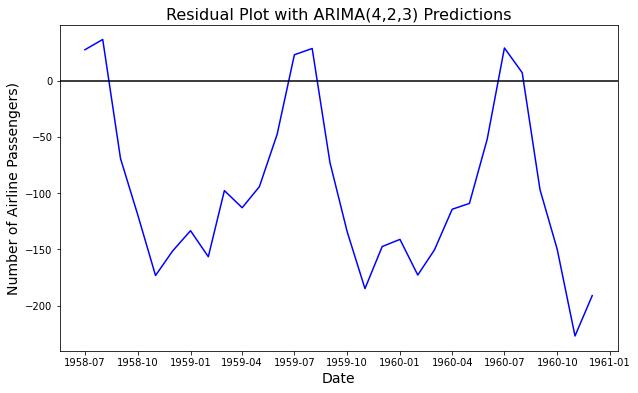

In [91]:

plt.figure(figsize=(10,6))
plt.plot(resid,color = 'blue') 
plt.ylabel('Number of Airline Passengers)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title(label = 'Residual Plot with ARIMA(4,2,3) Predictions', fontsize=16) 
plt.axhline(0, color = 'k', ls = '-')
plt.show();

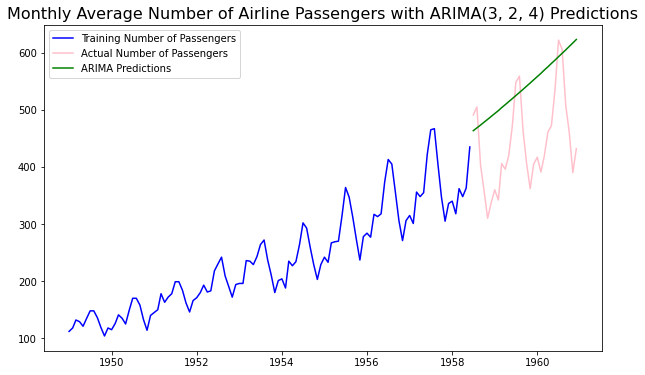

In [92]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train.index, train['passengers'], color = 'blue', label = 'Training Number of Passengers')

# Plot testing data.
plt.plot(test.index, test['passengers'], color = 'pink', label = 'Actual Number of Passengers')

# Plot predicted test values.
plt.plot(test.index, forecast, color = 'green', label = 'ARIMA Predictions')

plt.legend(loc = 'upper left')
plt.title(label = 'Monthly Average Number of Airline Passengers with ARIMA(3, 2, 4) Predictions', fontsize=16);

In [93]:
from sklearn.metrics import r2_score
test['predicted_passengers'] = forecast
r2_score(test['passengers'], test['predicted_passengers'])



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


-1.5158412858390542

In [67]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [68]:
#We use the ‘Augmented Dickey-Fuller Test’ to check whether the data is stationary or not which is available in the ‘pmdarima’ package.
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df)

#From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.


(0.01, False)

In [69]:
df.shape

(144, 1)

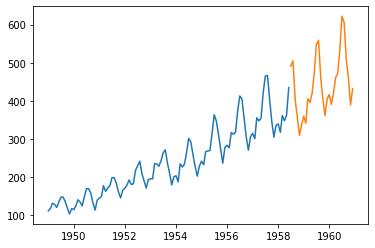

In [70]:
train=df[:114]
test=df[-30:]
plt.plot(train)
plt.plot(test)

In [71]:
model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=751.656, BIC=756.886, Time=0.053 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=748.975, BIC=759.435, Time=0.163 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=749.651, BIC=760.111, Time=0.145 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=749.666, BIC=752.282, Time=0.012 seconds
Fit ARIMA(1,1,0)x(0,1,0,12) [intercept=True]; AIC=748.988, BIC=756.833, Time=0.055 seconds
Fit ARIMA(1,1,0)x(2,1,0,12) [intercept=True]; AIC=750.464, BIC=763.540, Time=0.529 seconds
Fit ARIMA(1,1,0)x(1,1,1,12) [intercept=True]; AIC=750.758, BIC=763.834, Time=0.298 seconds
Fit ARIMA(1,1,0)x(0,1,1,12) [intercept=True]; AIC=749.281, BIC=759.742, Time=0.185 seconds


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA(1,1,0)x(2,1,1,12) [intercept=True]; AIC=747.055, BIC=762.746, Time=1.923 seconds
Near non-invertible roots for order (1, 1, 0)(2, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,1,0)x(1,1,0,12) [intercept=True]; AIC=750.559, BIC=758.404, Time=0.132 seconds
Fit ARIMA(2,1,0)x(1,1,0,12) [intercept=True]; AIC=750.439, BIC=763.515, Time=0.326 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=749.902, BIC=762.977, Time=0.295 seconds
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=749.360, BIC=759.821, Time=0.170 seconds


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA(2,1,1)x(1,1,0,12) [intercept=True]; AIC=751.875, BIC=767.566, Time=0.507 seconds
Total fit time: 4.803 seconds


In [72]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  114
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood                -367.528
Date:                              Mon, 04 Jan 2021   AIC                            747.055
Time:                                      19:18:04   BIC                            762.746
Sample:                                           0   HQIC                           753.407
                                              - 114                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.087e-05      0.021      0.003      0.997      -0.041       0.041
ar.L1         -0.2593      0.093     -2.799      0.005      -0.441      -0.078
ar.S.L12       0.7227      0.352      2.055      0.040       0.034       1.412
ar.S.L24       0.2761      0.100      2.771      0.006       0.081       0.471
ma.S.L12      -0.9778      3.169     -0.309      0.758      -7.190       5.234
sigma2        75.0390    211.368      0.355      0.723    -339.235     489.313
===================================================================================
Ljung-Box (Q):                       36.41   Jarque-Bera (JB):                 3.07
Prob(Q):                              0.63   Prob(JB):                         0.21
Heteroskedasticity (H):               1.00   Skew:                             0.41
Prob(H) (two-sided):                  1.00   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
prediction = pd.DataFrame(model.predict(n_periods = 30),index=test.index)
prediction.columns = ['predicted_passengers']
prediction

,predicted_passengers
date,
1958-07-01,479.266568
1958-08-01,478.689060
1958-09-01,413.902832
1958-10-01,355.082135
1958-11-01,312.292168
1958-12-01,346.138229
1959-01-01,352.097192
1959-02-01,329.530262
1959-03-01,379.855437


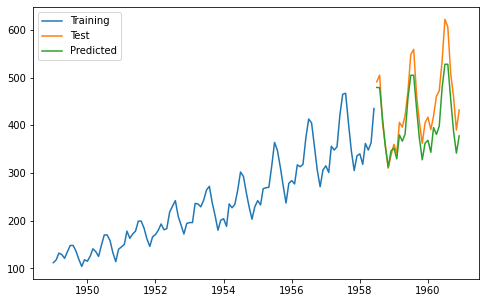

In [74]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [75]:
from sklearn.metrics import r2_score
test['predicted_passengers'] = prediction
r2_score(test['passengers'], test['predicted_passengers'])

# R2 Score for test data set

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.649941408822047